## About the Data 

The main dataset, obtained from from a subset of The National Centers for Environmental Information (NCEI) Daily Global Historical Climatology Network (GHCN-Daily), is the record of temperatures from stations near Ann Arbor, Michigan, United States. Each row in the assignment datafile corresponds to a single observation. As our data, we have:

- id : station identification code
- date : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
- element : indicator of element type
- TMAX : Maximum temperature (tenths of degrees C)
- TMIN : Minimum temperature (tenths of degrees C)
- value : data value for element (tenths of degrees C)

Alright, with this brief introduction, hands-on!

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime

df = pd.read_csv('fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

## Data Exploration

In [2]:
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [6]:
df.dtypes

ID            object
Date          object
Element       object
Data_Value     int64
dtype: object

With the `dtypes` attribute executed previously, we can see an issue: the "Date" column isn't in datetime format, but in object, representation in Pandas to string. Besides that, we need to take care with leap years, which had February 29th, while another years haven't; we need to remove them too.

## Data Cleansing

First of all, we need to clear our data so they can be utils to us. Those will be our "quests":
- Format "Date" column to datetime64;
- Remove leap days from the data, such as February 29th;
- Remove ununsed columns, such as "ID" from station;
- Converting tenths of degrees C to single degrees C;

In [4]:
# removing the "ID" column
df.drop('ID', axis=1, inplace=True)
# removing February 29th from the data
df = df[~df['Date'].str.contains('02-29')]
# converting date to datetime format
df['Date'] = pd.to_datetime(df['Date'])
# converting tenths of degrees C to single degree C
df['Data_Value'] = df['Data_Value'].apply(lambda x: x / 10)

df['Year'] = df['Date'].apply(lambda x: x.year)
df['Month-Day'] = df['Date'].apply(lambda x: x.strftime('%m-%d'))

"Month-Day" was created with format 'month-day', to serve as parameter to groupby, that will be used later.

In [5]:
df.head()

,Date,Element,Data_Value,Year,Month-Day
0,2014-11-12,TMAX,2.2,2014,11-12
1,2009-04-29,TMIN,5.6,2009,04-29
2,2008-05-26,TMAX,27.8,2008,05-26
3,2005-11-11,TMAX,13.9,2005,11-11
4,2014-02-27,TMAX,-10.6,2014,02-27


In [7]:
df.shape

(165085, 4)

With the `shape` attribute, we can see that our dataframe have more than 165k rows, so, how do we build a chart with this? Well, naturally, there's a lot of observations about the same day, so, we need to look at all the "same days" of different years to get the record for these day. For example:

| Date       | Element | Data_Value |
|------------|---------|------------|
| 01/01/2005 |   TMAX  |     20     |
| 01/01/2006 |   TMAX  |     30     |
| 01/01/2007 |   TMAX  |     25     |
| 01/01/2008 |   TMAX  |     12     |
| 01/01/2009 |   TMAX  |     32     |
| 01/01/2010 |   TMAX  |     19     |
| 01/01/2011 |   TMAX  |     21     |
| 01/01/2012 |   TMAX  |     30     |
| 01/01/2013 |   TMAX  |     33     |
| 01/01/2014 |   TMAX  |     26     |

We need to look to all "the same days" in our range (2005-2014) and search to the records of maximum and minimum temperatures. In our example, the maximum temperature reached in January 1st is 33 degrees C.

With our original dataframe cleaned, we can start to create new dataframes from it, which will be used to generate our plot. To create them, we need to:
- Split the original df into a range of years from 2005 to 2014;
    - From these, get two dataframes: one containing the maximum temperatures (TMAX) and another containing the minimum (TMIN);
- Split the original df where year of the data = 2015;
    - From these, the same as above;
- With the dataframes created as "sub-dataframes", we need to compair the maximum and minimum temperatures in 2005-2014 to the 2015 data, to discover how much 2015 temperatures surpassed the record, if they do.

In [6]:
# separating 2005-2014 data from 2015 data
ten_years = df.loc[df['Year'] < 2015]
ten_years = ten_years.sort_values(by='Date')
weather_2015 = df.loc[df['Year'] == 2015]
weather_2015 = weather_2015.sort_values(by='Date')

# getting the maximum and minimum temperatures (2005-2014)
maxTemperature = ten_years.groupby('Month-Day')['Data_Value', 'Date'].max()
minTemperature = ten_years.groupby('Month-Day')['Data_Value', 'Date'].min()

# getting the maximum and minimum temperatures (2015)
maxTemperature2015 = weather_2015.groupby('Month-Day')['Data_Value', 'Date'].max()
minTemperature2015 = weather_2015.groupby('Month-Day')['Data_Value', 'Date'].min()

# getting the temperature records broken in 2015
records_max = maxTemperature2015[maxTemperature2015['Data_Value'] > maxTemperature['Data_Value']]
records_min = minTemperature2015[minTemperature2015['Data_Value'] < minTemperature['Data_Value']]

In [7]:
records_max.head()

,Data_Value,Date
Month-Day,,
02-09,8.3,2015-02-09
04-17,27.8,2015-04-17
05-07,30.6,2015-05-07
05-08,33.3,2015-05-08
05-11,30.6,2015-05-11


In [8]:
records_min.head()

,Data_Value,Date
Month-Day,,
01-05,-15.5,2015-01-05
01-11,-20.0,2015-01-11
02-03,-23.8,2015-02-03
02-14,-23.9,2015-02-14
02-15,-26.0,2015-02-15


## Data Visualization

Alright, with all ready, we can start to create our beloved chart. First of all, let's create an array numpy, with data type = datetime64, which goes from 2015-01-01 to 2015-12-31, to serve as our parameter to x-axis.

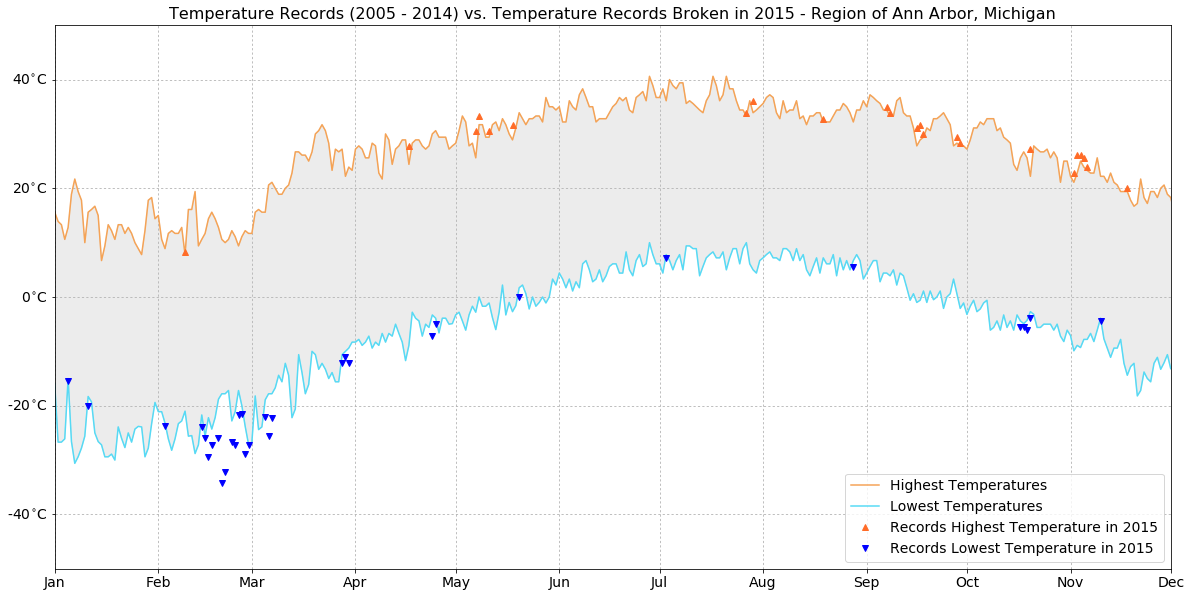

In [11]:
# getting date range used as parameter to the x-axis 
date_range = list(map(pd.to_datetime, np.arange('2015-01-01','2016-01-01', dtype='datetime64[D]')))

# defining figure size
plt.figure(figsize=(20, 10)) 
ax = plt.gca()

# plotting our data
ax.plot(date_range, maxTemperature['Data_Value'], color='#F5A356', linewidth=1.5)
ax.plot(date_range, minTemperature['Data_Value'], color='#56DAF5', linewidth=1.5)
ax.plot(records_max['Date'], records_max['Data_Value'], '^', color='#FF6C28')
ax.plot(records_min['Date'], records_min['Data_Value'], 'v', color='blue')

# defining axis range (min x, max x, min y, max y)
ax.axis(['2015-01', '2015-12', -50, 50])

# defining the labels to the axes
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ylabels = [str(x)+'$^{\circ}$C' for x in range(-60,60,20)]

# applying labels
ax.set_xticklabels(xlabels, fontsize=14)
ax.set_yticklabels(ylabels, fontsize=14)

# filling with gray between the two lines
plt.fill_between(date_range, minTemperature['Data_Value'], maxTemperature['Data_Value'], color='gray', alpha=.15)

# setting title, legend and grid to our figure
plt.title('Temperature Records (2005 - 2014) vs. Temperature Records Broken in 2015 - Region of Ann Arbor, Michigan', fontsize=16)
plt.legend(['Highest Temperatures', 'Lowest Temperatures', 'Records Highest Temperature in 2015',
            'Records Lowest Temperature in 2015'], loc='lower right', fontsize=14)
plt.grid(linestyle='dotted')

# saving figure :D
plt.savefig("temperatures.png")

# showing the figure
plt.show()

## Conclusions

This project was made as Assignment 2 from the Applied Plotting, Charting & Data Representation in Python course by [Coursera](#https://www.coursera.org/). I've learned a lot about data visualization (and still learning) and this project gave me confidence to keeping carry on. Sorry for my bad vocabulary, putting this on English without any translator was a pretty challenge, and I'm very happy. If you read until here, thanks, and I wish the best of luck to you. :D